In [24]:
import json
import numpy as np
from pp_utils import TimeStepStats, LinearSolveStats
from matplotlib import pyplot as plt
from plot_utils import *

with open("../stats/fpm_1_sliding.json", "r") as f:
    contents = json.load(f)

data = [TimeStepStats.from_json(x) for x in contents]

Text(0.5, 0, '# matrix')

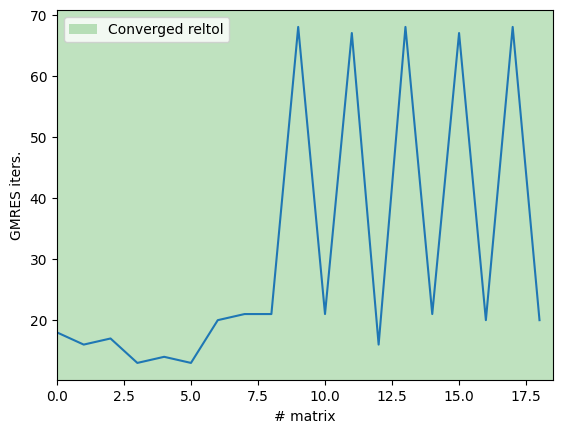

In [25]:
# %matplotlib ipympl

color_converged_reason(data)
plt.plot(get_gmres_iterations(data))
plt.ylabel('GMRES iters.')
plt.xlabel('# matrix')
# plt.yscale('log')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


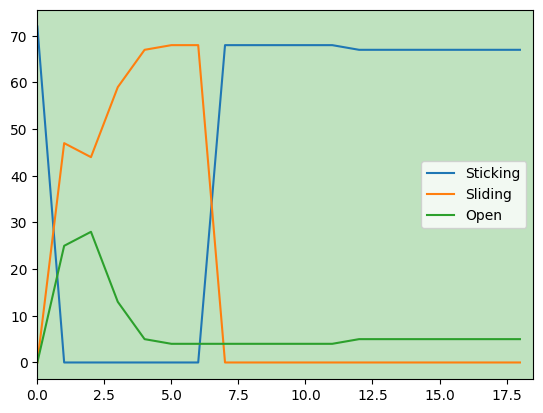

In [26]:
sticking, sliding, open_ = get_num_sticking_sliding_open(data)
color_converged_reason(data, legend=False)
plt.plot(sticking, label='Sticking')
plt.plot(sliding, label='Sliding')
plt.plot(open_, label='Open')
plt.legend()

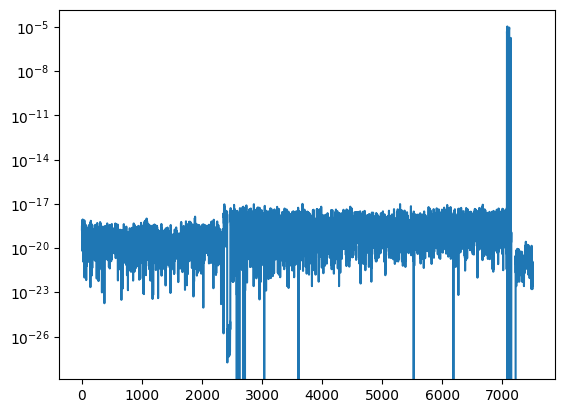

In [27]:
import scipy.sparse
from pathlib import Path
from plot_utils import *


def load_matrix_rhs(data: Sequence[TimeStepStats], idx: int):
    flat_data: list[LinearSolveStats] = [y for x in data for y in x.linear_solves]
    load_dir = Path('../matrices')
    mat = scipy.sparse.load_npz(load_dir / flat_data[idx].matrix_id)
    rhs = np.load(load_dir / flat_data[idx].rhs_id)
    return mat, rhs

mat, rhs = load_matrix_rhs(data, 1)
# spy(mat)
plt.plot(abs(rhs))
plt.yscale('log')

In [28]:
import porepy as pp
import numpy as np
from mat_utils import *
from plot_utils import *
from fpm_1 import make_model

model = make_model()
model.prepare_simulation()

model.time_manager.increase_time()
model.time_manager.increase_time_index()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()

model.assemble_linear_system()

model._initialize_solver()
block_matrix = make_block_mat(model, mat)
eq_blocks = model.make_equations_indices()
var_blocks = model.make_variables_indices()

model.linear_system = mat, rhs

rhs_permuted = model.permutation @ rhs

reordered_mat, preconditioner = model._prepare_solver()

/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


Solve  took: 0.23


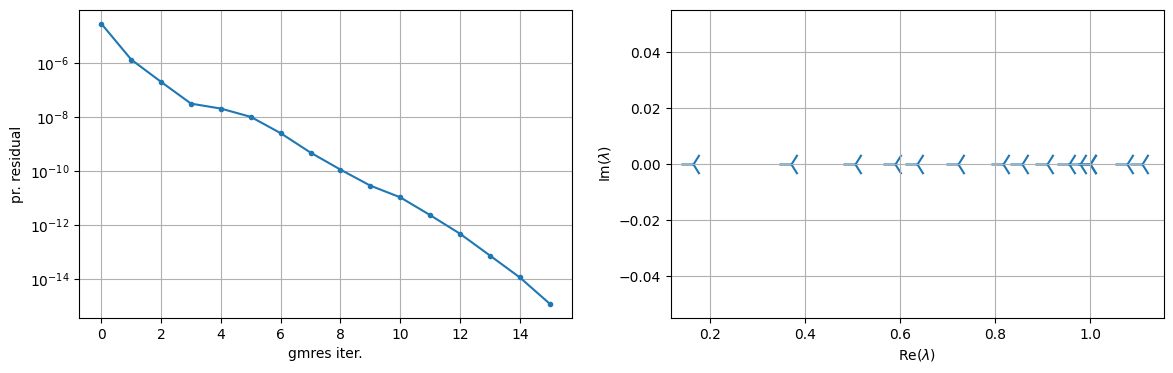

In [29]:
solve_petsc(reordered_mat, preconditioner, rhs=rhs_permuted)

Solve  took: 1.03


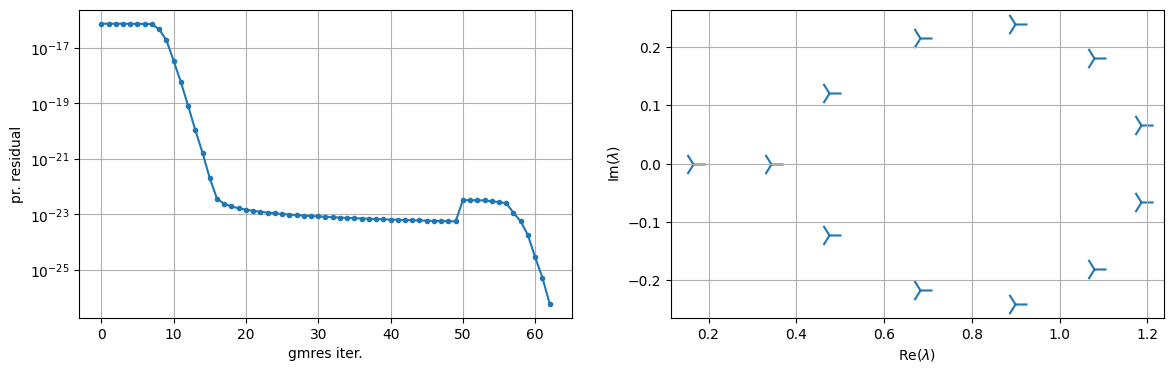

In [30]:
Omega_amg = preconditioner.Omega_inv
rhs_omega = rhs_permuted[preconditioner.sep:]
Omega = bmat([
    [model.Bp, model.C2p],
    [model.C1p, model.Ap]
])
solve_petsc(Omega, Omega_amg, rhs=rhs_omega)

Solve  took: 0.15


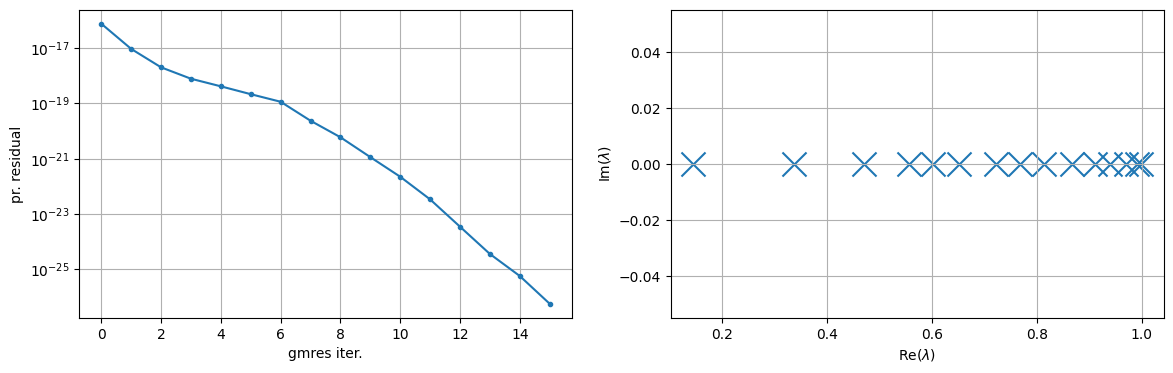

In [31]:
B_amg = Omega_amg.B_inv
rhs_B = rhs_omega[:Omega_amg.sep]
B = B_amg.get_matrix()
solve_petsc(B, B_amg, rhs_B)

Solve  took: 0.01


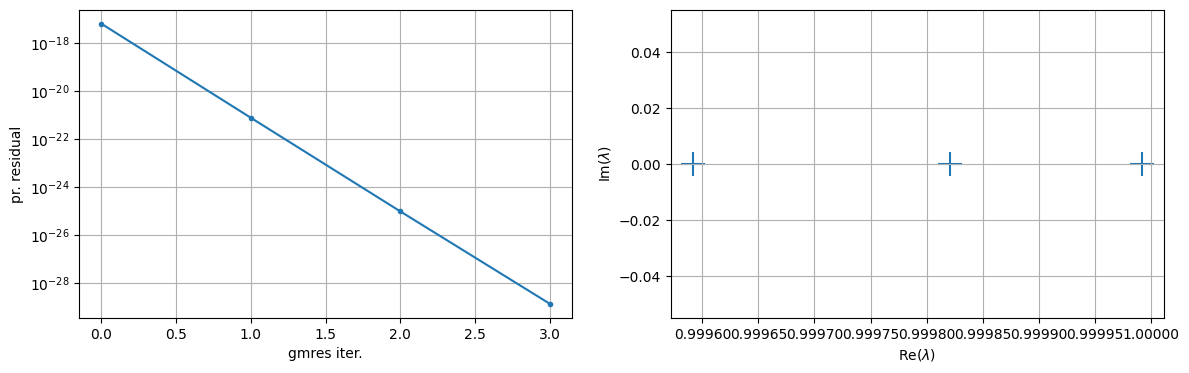

In [32]:
S_A_amg = Omega_amg.S_A_inv
rhs_A = rhs_omega[Omega_amg.sep:]
S_A = S_A_amg.get_matrix()
solve_petsc(S_A, S_A_amg, rhs_A)

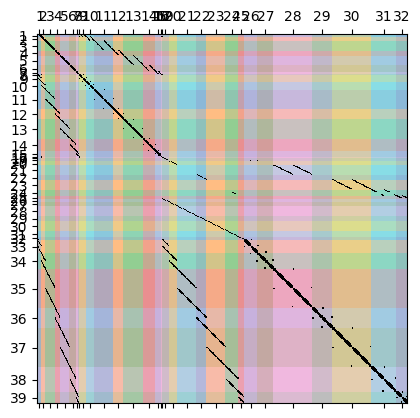

In [33]:
dim_max = model.mdg.dim_max()
sd_ambient = model.mdg.subdomains(dim=dim_max)
sd_lower = [k for i in reversed(range(0, dim_max)) for k in model.mdg.subdomains(dim=i)]
sd_frac = model.mdg.subdomains(dim=dim_max - 1)
intf = model.mdg.interfaces()
intf_frac = model.mdg.interfaces(dim=dim_max - 1)

var_idx = get_variables_indices(
    variable_to_idx=make_variable_to_idx(model),
    md_variables_groups=[
        [model.pressure(sd_ambient)],
        [model.displacement(sd_ambient)],
        [model.pressure(sd_lower)],
        [model.interface_darcy_flux(intf)],
        [model.contact_traction(sd_frac)],
        [model.interface_displacement(intf_frac)],
    ],
)

eq_idx = get_equations_indices(
    equation_to_idx=make_equation_to_idx(model),
    equations_group_order=[
        [("mass_balance_equation", sd_ambient)],  # 0
        [("momentum_balance_equation", sd_ambient)],  # 1
        [("mass_balance_equation", sd_lower)],  # 2
        [("interface_darcy_flux_equation", intf)],  # 3
        [
            ("normal_fracture_deformation_equation", sd_lower),  # 4
            ("tangential_fracture_deformation_equation", sd_lower),
        ],
        [("interface_force_balance_equation", intf)],  # 5
    ],
)

# diagnostics = model.run_diagnostics(grouping='dense')
# model.plot_diagnostics(diagnostics, key='max')
# plot_mat(concatenate_blocks(block_matrix, eq_idx[3], var_idx[3]))
color_spy(
    block_matrix,
    eq_idx[2] + eq_idx[3] + eq_idx[4] + eq_idx[5],
    var_idx[2] + var_idx[3] + var_idx[4] + var_idx[5],
); plt.show()
x = concatenate_blocks(
    block_matrix,
    eq_idx[2] + eq_idx[3] + eq_idx[4] + eq_idx[5],
    var_idx[2] + var_idx[3] + var_idx[4] + var_idx[5],
)
# plot_eigs(x)

In [34]:
cond(x)

1.3062095552718714e+21

In [35]:
x = concatenate_blocks(
    block_matrix,
    eq_idx[3],
    var_idx[3],
)

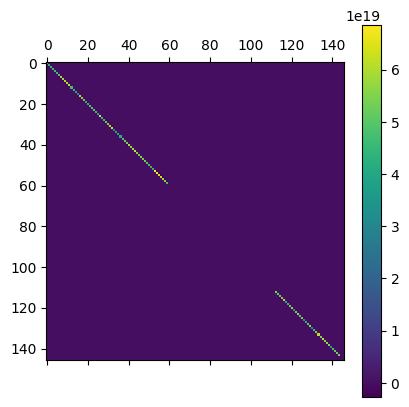

In [36]:
plot_mat(x, log=False)

In [37]:
x.data.max()

6.858145472374343e+19

In [38]:
intf = model.mdg.interfaces(dim=1)
model.interface_darcy_flux_equation(intf)

Operator 'interface_darcy_flux_equation' formed by Operations.sub with 2 children.

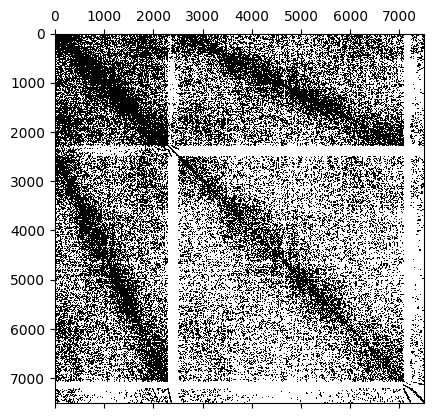

In [39]:
spy(mat)

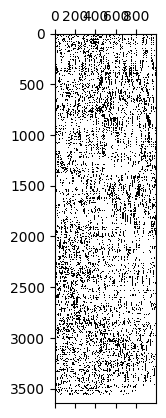

In [40]:
sd = model.mdg.subdomains()
spy(model.pressure_trace(sd).value_and_jacobian(model.equation_system).jac[:, :1000])

In [41]:
subdomains = model.mdg.subdomains()
interfaces: list[pp.MortarGrid] = model.subdomains_to_interfaces(subdomains, [1])
projection = pp.ad.MortarProjections(model.mdg, subdomains, interfaces, dim=1)
discr = model.darcy_flux_discretization(subdomains)
p = model.pressure(subdomains)

boundary_operator = model._combine_boundary_operators(  # type: ignore[call-arg]
    subdomains=subdomains,
    dirichlet_operator=model.pressure,
    neumann_operator=model.darcy_flux,
    bc_type=model.bc_type_darcy_flux,
    name="bc_values_darcy",
)

res = discr.bound_pressure_face @ (
    projection.mortar_to_primary_int @ model.interface_darcy_flux(interfaces)
)

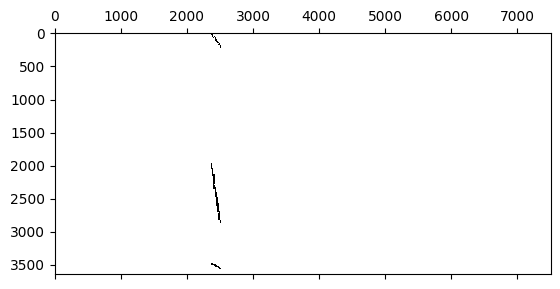

In [42]:
spy(res.value_and_jacobian(model.equation_system).jac)

In [43]:
data = res.value_and_jacobian(model.equation_system).jac.data
abs(data).min()

0.55859375

In [44]:
model.discretize()